In [ ]:
# Install the required packages
!pip install -q langgraph llangchain_huggingface langchain_google_genai

## Setting Up Environment

In [3]:

import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv

# Load environment variables from .env file,
load_dotenv()

# Get API key from environment,
gemini_api_key = os.getenv("GEMINI_API_KEY")

# Initialize our LLM
vision_llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=gemini_api_key, temperature=0)
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=gemini_api_key, temperature=0)

In [4]:
import base64
from langchain_core.messages import HumanMessage


def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""



def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b


tools = [
    divide,
    extract_text
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

## Defining Agent’s State

AnyMessage is a class from Langchain that defines messages, and add_messages is an operator that adds the latest message rather than overwriting it with the latest state.

This is a new concept in LangGraph, where you can add operators in your state to define the way they should interact together.

In [5]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The input document
    input_file: Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

## The nodes

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


def assistant(state: AgentState):
    # System message
    textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image = state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computatio without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}

## The ReAct Pattern
Allow me to explain the approach in this agent. The agent follows what’s known as the ReAct pattern (Reason-Act-Observe)

Reason about his documents and requests
Act by using appropriate tools
Observe the results
Repeat as necessary until I’ve fully addressed his needs
This is a simple implementation of an agent using LangGraph.

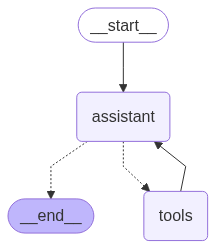

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Example 1: Simple Calculations

In [8]:
messages = [HumanMessage(content="Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages, "input_file": None})

In [9]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (847f0a02-8f01-4da5-a73c-fcd43db97270)
 Call ID: 847f0a02-8f01-4da5-a73c-fcd43db97270
  Args:
    a: 6790.0
    b: 5.0
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

1358


## Example 2: Analyzing Master Wayne’s Training Documents

In [13]:
messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ? including the quantity as well.")]

messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

In [14]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ? including the quantity as well.
================================== Ai Message ==================================
Tool Calls:
  extract_text (0554e749-1101-4389-b644-087be950562d)
 Call ID: 0554e749-1101-4389-b644-087be950562d
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation
EVENING
clean and jerk lifts—3 reps/8 sets. 262 lbs.
5 sets metabolic conditioning:
¼ mile run
21 kettlebell swings
12 pull-ups
30 minutes flexibility
30 minutes sparring

MONDAY 2/21
MORNING
30 minute jog
30 minutes traditional kata (focus on Japanese forms)
EVENING
5 sets 20 foot rope climb
30 minutes gymnastic 